# Digit Classification with KNN and Naive Bayes

This project implements image recognition system for classifying digits.

Reference links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/
* To implement on Tensorflow: https://www.tensorflow.org/tutorials/keras/basic_classification. 
It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, we can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.24.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which we should use in all the experiments below.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
#X, Y = fetch_openml(name='mnist_784', version=1, return_X_y=True, cache=False)
X, Y = fetch_openml(name='mnist_784', version=1, return_X_y=True, as_frame=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]


data shape:  (70000, 784)
label shape: (70000,)


### Part 1:

Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* can use `plt.rc()` for setting the colormap, for example to black and white.
* can use `plt.subplot()` for creating subplots.
* can use `plt.imshow()` for rendering a matrix.
* can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

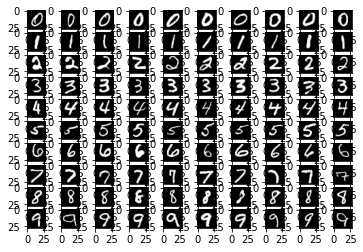

In [4]:
def P1(num_examples=10):

#num_examples = 10
    for j in range(10):
        num_example = num_examples
        for i in range(X.shape[0]):
            if num_example < 1:
                break
            if int(Y[i]) == j:
                plt.subplot(10,num_examples,num_example+j*num_examples)
                plt.imshow(np.array(X[i]).reshape(28, 28), cmap=plt.get_cmap('gray'))
                num_example -= 1
    
    plt.show()

P1(10)

### Part 2:

Produce k-Nearest Neighbors models with k $\in$ [1,3,5,7,9].  Evaluate and show the accuracy of each model. For the 1-Nearest Neighbor model, additionally show the precision, recall, and F1 for each label. Which digit is the most difficult for the 1-Nearest Neighbor model to recognize?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* can use `classification_report` to get precision, recall, and F1 results.

In [5]:
def P2(k_values):

# Produce k-Nearest Neighbors models 
    for k in k_values:
        # train the k-Nearest Neighbor classifier with the current value of `k`
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(mini_train_data, mini_train_labels)

        # evaluate the model and update the accuracies list
        score = model.score(dev_data, dev_labels)
        print("k=%d, accuracy=%.2f%%" % (k, score * 100))

# For the 1-Nearest Neighbor model

    model = KNeighborsClassifier(n_neighbors=1)
    model.fit(mini_train_data, mini_train_labels)
    test_predicted_labels = model.predict(dev_data)
    target_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    print("\n----Classification report to get precision, recall, and F1 results for the 1-Nearest Neighbor model----\n ")
    print(classification_report(dev_labels, test_predicted_labels, target_names=target_classes))
    

k_values = [1, 3, 5, 7, 9]
P2(k_values)


k=1, accuracy=88.40%
k=3, accuracy=87.60%
k=5, accuracy=88.20%
k=7, accuracy=87.70%
k=9, accuracy=87.50%

----Classification report to get precision, recall, and F1 results for the 1-Nearest Neighbor model----
 
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       106
           1       0.89      0.98      0.93       118
           2       0.90      0.79      0.84       106
           3       0.93      0.87      0.90        97
           4       0.91      0.85      0.88        92
           5       0.86      0.88      0.87        88
           6       0.92      0.92      0.92       102
           7       0.85      0.94      0.89       102
           8       0.83      0.77      0.80        94
           9       0.80      0.86      0.83        95

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.89      0.88      0.88      1000



**Output notes:**

k=1 achieved highest accuracy of 88.40% on validation data. Out of the precision values from all the digits above, we can see the digit 9 obtains the lowest classification accuracy of 80%. Hence, digit 9 is the most difficult for the 1-Nearest Neighbor model to recognize.

### Part 3:

Produce 1-Nearest Neighbor models using training data of various sizes. Evaluate and show the performance of each model.  Additionally, show the time needed to measure the performance of each model.

Notes:
* Train on subsets of the train set.  For each subset, take just the first part of the train set without re-ordering.
* Evaluate on the dev set.
* can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* can use `time.time()` to measure elapsed time of operations.

In [7]:
def P3(train_sizes, accuracies):

# Produce k-Nearest Neighbors models 
    for size in train_sizes:
        # train the k-Nearest Neighbor classifier with the current value of `k`
        model = KNeighborsClassifier(n_neighbors=1)
        model.fit(train_data[:size], train_labels[:size])
        start_time = time.time()
        # evaluate the model and update the accuracies list
        score = model.score(dev_data, dev_labels)
        print("size=%d, accuracy=%.2f%% Elapsed_time = %.2f seconds" % (size, score * 100, (time.time() - start_time)))
        accuracies.append(score)
        time.time()

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
P3(train_sizes, accuracies)

size=100, accuracy=70.20% Elapsed_time = 0.05 seconds
size=200, accuracy=79.10% Elapsed_time = 0.03 seconds
size=400, accuracy=81.10% Elapsed_time = 0.03 seconds
size=800, accuracy=86.60% Elapsed_time = 0.05 seconds
size=1600, accuracy=90.50% Elapsed_time = 0.07 seconds
size=3200, accuracy=92.70% Elapsed_time = 0.14 seconds
size=6400, accuracy=93.90% Elapsed_time = 0.23 seconds
size=12800, accuracy=95.20% Elapsed_time = 0.47 seconds
size=25600, accuracy=96.30% Elapsed_time = 0.94 seconds


### Part 4:

Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. Show $R^2$ of the linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data.  What's wrong with using linear regression here?

Apply a transformation to the predictor features and a transformation to the outcome that make the predictions more reasonable.  Show $R^2$ of the improved linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data - be sure to display accuracies and training set sizes in appropriate units.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hint re: predictor feature transform: Accuracy increases with training set size logarithmically.
* Hint re: outcome transform: When y is a number in range 0 to 1, then odds(y)=y/(1-y) is a number in range 0 to infinity.

original model:
R^2 on training: 0.4177
Predicted accuracy of 1NN model for n=60000:  1.2362
Predicted accuracy of 1NN model for n=120000:  1.6374
Predicted accuracy of 1NN model for n=1000000:  7.5225

Improved model with log transform of input(better R2):
R^2 on training: 0.9068
Predicted accuracy of 1NN model for n=60000:  1.0336
Predicted accuracy of 1NN model for n=120000:  1.0643
Predicted accuracy of 1NN model for n=1000000:  1.1583

Improved model with odds transform of outcome(predicted accuracy<1):
R^2 on training: 0.8649
Predicted accuracy of 1NN model for n=60000:  0.9833
Predicted accuracy of 1NN model for n=120000:  0.9911
Predicted accuracy of 1NN model for n=1000000:  0.9989

Improved model with log transform of input and odds transform of outcome (better R2 & predicted accuracy<1):
R^2 on training: 0.9395
Predicted accuracy of 1NN model for n=60000:  0.9631
Predicted accuracy of 1NN model for n=120000:  0.9666
Predicted accuracy of 1NN model for n=1000000:  0.9741
[0.9

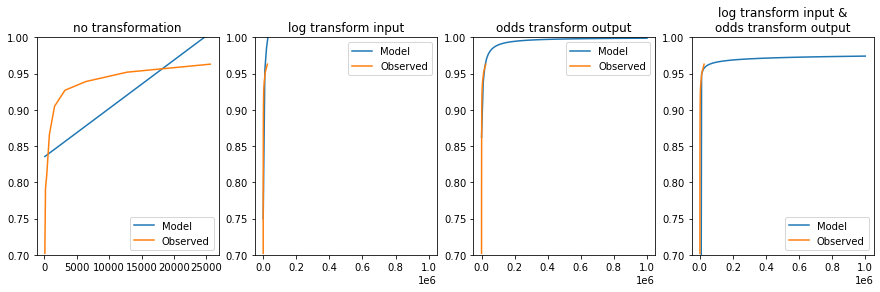

In [8]:
def P4():

    prob_to_odds = lambda x:x/(1.0-x)
    odds_to_prob = lambda x:x/(1.0 + x)

    x_sizes = np.array(train_sizes)[:, np.newaxis]
    x_logsizes = np.array(np.log(train_sizes))[:, np.newaxis]
    y_oddsaccuracies = np.array(list(map(prob_to_odds, accuracies)))
    lr1 = LinearRegression()
    lr2 = LinearRegression()
    lr3 = LinearRegression()
    lr4 = LinearRegression()

    lr1.fit(x_sizes, accuracies)
    lr2.fit(x_logsizes, accuracies)
    lr3.fit(x_sizes, y_oddsaccuracies)
    lr4.fit(x_logsizes, y_oddsaccuracies)

    print("original model:")
    print("R^2 on training: %.4f" %lr1.score(x_sizes, accuracies))
    print("Predicted accuracy of 1NN model for n=60000:  %.4f"% lr1.predict([[60000]]))
    print("Predicted accuracy of 1NN model for n=120000:  %.4f"% lr1.predict([[120000]]))
    print("Predicted accuracy of 1NN model for n=1000000:  %.4f"% lr1.predict([[1000000]]))
    print()
    print("Improved model with log transform of input(better R2):")
    print("R^2 on training: %.4f" %lr2.score(x_logsizes, accuracies))
    print("Predicted accuracy of 1NN model for n=60000:  %.4f"% lr2.predict([[np.log(60000)]]))
    print("Predicted accuracy of 1NN model for n=120000:  %.4f"% lr2.predict([[np.log(120000)]]))
    print("Predicted accuracy of 1NN model for n=1000000:  %.4f"% lr2.predict([[np.log(1000000)]]))
    print()
    print("Improved model with odds transform of outcome(predicted accuracy<1):")
    print("R^2 on training: %.4f" %lr3.score(x_sizes, y_oddsaccuracies))
    print("Predicted accuracy of 1NN model for n=60000:  %.4f"% odds_to_prob(lr3.predict([[60000]])))
    print("Predicted accuracy of 1NN model for n=120000:  %.4f"% odds_to_prob(lr3.predict([[120000]])))
    print("Predicted accuracy of 1NN model for n=1000000:  %.4f"% odds_to_prob(lr3.predict([[1000000]])))
    print()
    print("Improved model with log transform of input and odds transform of outcome (better R2 & predicted accuracy<1):")
    print("R^2 on training: %.4f" %lr4.score(x_logsizes, y_oddsaccuracies))
    print("Predicted accuracy of 1NN model for n=60000:  %.4f"% odds_to_prob(lr4.predict([[np.log(60000)]])))
    print("Predicted accuracy of 1NN model for n=120000:  %.4f"% odds_to_prob(lr4.predict([[np.log(120000)]])))
    print("Predicted accuracy of 1NN model for n=1000000:  %.4f"% odds_to_prob(lr4.predict([[np.log(1000000)]])))

    print(odds_to_prob(lr3.predict([[60000]])))
    plt.figure(figsize=(15, 4))
    plt.ylim(0.7, 1.0)

    ax = plt.subplot(1, 4, 1)
    ax.set_ylim([0.7, 1.0])
    x_values = np.linspace(100, 25000, 100)
    plt.title("no transformation")
    plt.plot(x_values, lr1.predict(x_values[:, np.newaxis]), label="Model")
    plt.plot(train_sizes, accuracies, label="Observed")
    plt.legend(loc="best")

    ax = plt.subplot(1, 4, 2)
    ax.set_ylim([0.7, 1.0])
    x_values = np.linspace(100, 1000000, 100)
    plt.title("log transform input")
    plt.plot(x_values, lr2.predict(np.log(x_values)[:, np.newaxis]), label="Model")
    plt.plot(train_sizes, accuracies, label="Observed")
    plt.legend(loc="best")

    ax = plt.subplot(1, 4, 3)
    ax.set_ylim([0.7, 1.0])
    x_values = np.linspace(100, 1000000, 100)
    plt.title("odds transform output")
    plt.plot(x_values, odds_to_prob(lr3.predict(x_values[:, np.newaxis])), label="Model")
    plt.plot(train_sizes, accuracies, label="Observed")
    plt.legend(loc="best")

    ax = plt.subplot(1, 4, 4)
    ax.set_ylim([0.7, 1.0])
    x_values = np.linspace(100, 1000000, 100)
    plt.title("log transform input &\nodds transform output")
    plt.plot(x_values, odds_to_prob(lr4.predict(np.log(x_values)[:, np.newaxis])), label="Model")
    plt.plot(train_sizes, accuracies, label="Observed")
    plt.legend(loc="best")


P4()


Output notes:

In the first plot above, the linear regression model with no transformation clearly shows that actual and predicted accuracy are far off from each other. Using the linear regression model, setting X=60000 yields a predicted accuracy of 1.362, which does not make sense, since you cannot have a predicted accuracy greater than 100%.

Hence, there is a need to do transformation of predictor feature(X) or outcome(Y).


### Part 5:

Produce a 1-Nearest Neighbor model and show the confusion matrix. Which pair of digits does the model confuse most often? Show the images of these most often confused digits.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.

[[101   0   1   0   0   0   1   1   2   0]
 [  0 116   1   0   0   0   0   0   1   0]
 [  1   4  84   2   2   0   2   4   6   1]
 [  0   2   0  84   0   6   0   2   3   0]
 [  0   0   1   0  78   0   0   2   0  11]
 [  2   0   0   1   1  77   5   0   2   0]
 [  1   2   1   0   1   2  94   0   1   0]
 [  0   1   1   0   0   0   0  96   0   4]
 [  1   5   4   3   1   3   0   1  72   4]
 [  0   1   0   0   3   2   0   7   0  82]]
4 of the 11 cases in which the digit 4 is confused with the digit 9.
4 of the 7 cases in which the digit 9 is confused with the digit 7.
4 of the 6 cases in which the digit 2 is confused with the digit 8.
4 of the 6 cases in which the digit 3 is confused with the digit 5.
4 of the 5 cases in which the digit 5 is confused with the digit 6.


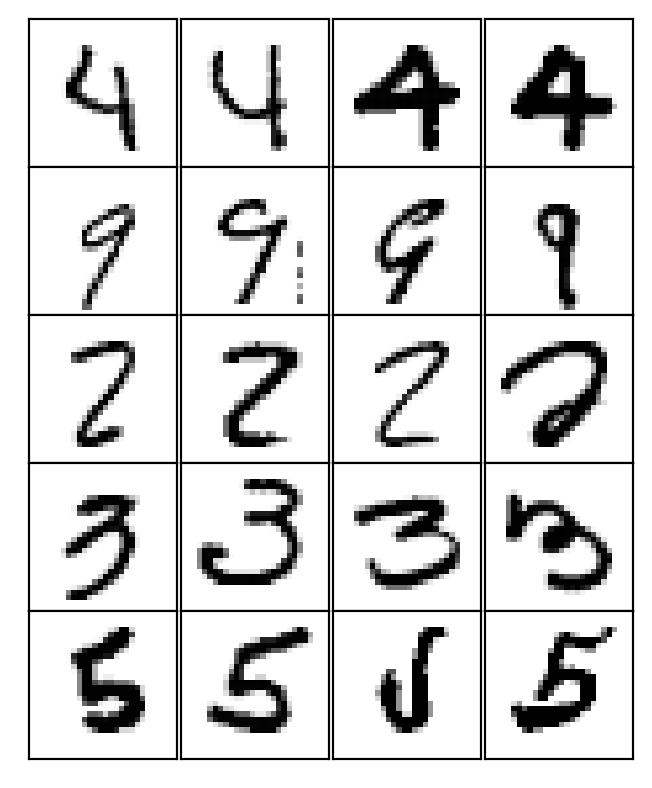

In [9]:
def P5():

    # Produce a 1-Nearest Neighbor model
    model = KNeighborsClassifier(n_neighbors=1)
    # Train on the mini train set
    model.fit(mini_train_data, mini_train_labels)
    # Evaluate performance on the dev set
    dev_pred = model.predict(dev_data)
    # Produce a confusion matrix
    confusion = confusion_matrix(y_true = dev_labels, y_pred = dev_pred)
    print(confusion)
    print
    # The diagonal elements corresponds to true positives. Let's get rid of it as we are interested to show the images of most often confused matrix.
    np.fill_diagonal(confusion, 0)
    confused_pairs_num = 5
    confused_digits_imagenum = 4
    # Display the top "confused_digits_imagenum" confused pairs
    dim = int(np.sqrt(X.shape[1]))
    # Define image properties
    plt.rc('image', cmap='Greys')
    plt.figure(figsize=(confused_digits_imagenum,confused_pairs_num), dpi=X.shape[1]/confused_digits_imagenum)
    for i in range(confused_pairs_num):
        # Find the position of the (left) top confused pair
        row,col = np.unravel_index(confusion.argmax(), confusion.shape)
        # Hence, row corresponds to the true digit and col to the (wrongly) predicted digit
        features_confused_digit = dev_data[(dev_labels == str(row)) & (dev_pred == str(col))]
        np.random.shuffle(features_confused_digit)
        print(f'{confused_digits_imagenum} of the {confusion.max()} cases in which the digit {row} is confused with the digit {col}.')

        for j in range(confused_digits_imagenum):
            # Create subplot
            plt.subplot(confused_pairs_num, confused_digits_imagenum, i*confused_digits_imagenum + j + 1)
            plt.subplots_adjust(wspace=0, hspace=0)
            # Hide tickmarks and scale
            ax = plt.gca()
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            # Plot the corresponding digit
            # (reshaped to square matrix/image)
            confused_digit = features_confused_digit[j].reshape((dim,dim))
            plt.imshow(confused_digit)
        # After displaying the top confused pair, minimize it to display the next confused pair
        confusion[row,col] = 0 

P5()


###### Output notes: 

**Below are the pair of digits that the model confuses the most often:**

- Digit 4 is confused with the digit 9, in 11 cases.

- Digit 9 is confused with the digit 7, in 7 cases.

- Digit 2 is confused with the digit 8, in 6 cases.

- Digit 3 is confused with the digit 5, in 6 cases.

- Digit 5 is confused with the digit 6, in 5 cases.

### Part 6:

A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.

Pick a weight, then produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
- Do not use the filter
- Filter the training data but not the dev data
- Filter the dev data but not the training data
- Filter both training data and dev data

Show the accuracies of the four models evaluated as described.  Try to pick a weight that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but you are likely to get the best results with the simplified version described above.

In [10]:
def P6():
    
    def gaussian_blur(d1_image):
        #dim = int(np.sqrt(d1_image.shape[0]))
        dim = 28
        d2_image = d1_image.reshape(dim, dim)
        d2_blur_image = np.zeros((dim, dim), dtype=float)
        # weight of centre pixel = 0.25
        # weight of Nearest neighbor on axis = 0.125
        # weight of Nearest neighbor on diagonal = 0.0625
        mask_blur = np.array([[.0625, .125, .0625], [.125, .25, .125] , [.0625 , .125, .0625] ])
        for i in range(1,dim-1):
            for j in range(1,dim-1):
                d2_blur_image[i][j] = d2_image[i-1][j-1]*mask_blur[0][0] + \
                                        d2_image[i-1][j]*mask_blur[0][1] + \
                                        d2_image[i-1][j+1]*mask_blur[0][2] + \
                                        d2_image[i][j-1]*mask_blur[1][0] + \
                                        d2_image[i][j]*mask_blur[1][1] + \
                                        d2_image[i][j+1]*mask_blur[1][2] + \
                                        d2_image[i+1][j-1]*mask_blur[2][0] +\
                                        d2_image[i+1][j]*mask_blur[2][1] + \
                                        d2_image[i+1][j+1]*mask_blur[2][2]
        return d2_blur_image.flatten()
    blur_mini_train_data = np.apply_along_axis(gaussian_blur, 1, mini_train_data)
    blur_dev_data = np.apply_along_axis(gaussian_blur, 1, dev_data)


# Do not use the filter
    model1 = KNeighborsClassifier(n_neighbors=1)
    # Train on the mini train set
    model1.fit(mini_train_data, mini_train_labels)
    # Evaluate performance on the dev set
    dev_pred = model1.predict(dev_data)
    score1 = model1.score(dev_data, dev_labels)
    print("Model with no Filter on train or dev data")
    print("accuracy=%.2f%%" % (score1 * 100))
    
# Filter the training data but not the dev data 
    model2 = KNeighborsClassifier(n_neighbors=1)
    # Train on the mini train set
    model2.fit(blur_mini_train_data, mini_train_labels)
    # Evaluate performance on the dev set
    dev_pred = model2.predict(dev_data)
    score2 = model2.score(dev_data, dev_labels)
    print("\nModel with Filter on training data but not the dev data")
    print("accuracy=%.2f%%" % (score2 * 100))
    
# Filter the dev data but not the training data
    
    model3 = KNeighborsClassifier(n_neighbors=1)
    # Train on the mini train set
    model3.fit(mini_train_data, mini_train_labels)
    # Evaluate performance on the dev set
    dev_pred = model3.predict(blur_dev_data)
    score3 = model3.score(blur_dev_data, dev_labels)
    print("\nModel with Filter on dev data but not the training data")
    print("accuracy=%.2f%%" % (score3 * 100))
    
# Filter both training data and dev data

    model4 = KNeighborsClassifier(n_neighbors=1)
    # Train on the mini train set
    model4.fit(blur_mini_train_data, mini_train_labels)
    # Evaluate performance on the dev set
    dev_pred = model4.predict(blur_dev_data)
    score4 = model4.score(blur_dev_data, dev_labels)
    print("\nModel with Filter on both training and dev data")
    print("accuracy=%.2f%%" % (score4 * 100))

P6()


Model with no Filter on train or dev data
accuracy=88.40%

Model with Filter on training data but not the dev data
accuracy=90.40%

Model with Filter on dev data but not the training data
accuracy=87.00%

Model with Filter on both training and dev data
accuracy=90.10%


### Part 7:

Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.

For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.

For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Use `MultinomialNB` to produce the model. 

Show the Bernoulli model accuracy and the Multinomial model accuracy.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* `sklearn`'s Naive Bayes methods can handle real numbers, but for this exercise explicitly do the mapping to categoricals. 

Does the multinomial version improve the results? Why or why not?

Accuracy of Binomial NB: 0.814
Accuracy of Multinomial NB: 0.807


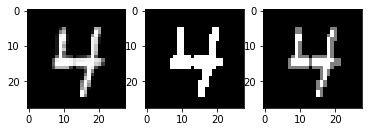

In [11]:
def P7():

    BinomialNB_model = BernoulliNB(binarize=0.1)
    BinomialNB_model.fit(mini_train_data, mini_train_labels)
    print ('Accuracy of Binomial NB: {0:.3f}'.format(BinomialNB_model.score(dev_data, dev_labels)))


    MultinomialNB_model = MultinomialNB()
    trinarized_train_data = np.where((mini_train_data > 0.1) & (mini_train_data < 0.9), 1, 
                                     np.where(mini_train_data > 0.9, 2, 0))
    trinarized_dev_data = np.where((dev_data > 0.1) & (dev_data < 0.9), 1, np.where(dev_data > 0.9, 2, 0))
    MultinomialNB_model.fit(trinarized_train_data, mini_train_labels)
    print ('Accuracy of Multinomial NB: {0:.3f}'.format(MultinomialNB_model.score(trinarized_dev_data, dev_labels)))

    plt.subplot(1, 3, 1)
    plt.imshow(np.array(mini_train_data[1]).reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.subplot(1, 3, 2)
    binarized_random_image = np.where(mini_train_data[1] < 0.1, 0, 1)
    plt.imshow(np.array(binarized_random_image).reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.subplot(1, 3, 3)
    plt.imshow(np.array(trinarized_train_data[1]).reshape(28, 28), cmap=plt.get_cmap('gray'))
        

P7()


**Output notes:**

As we can see from the accuracy here, multinomial version does not improve the result. In fact, there is just a marginal difference. If we change the threshold to 0.25 and 0.75, the accuarcy of Multinomial model is even worse(below 0.809). Since feature vectors are binary here, a greater accuracy of a Binomial NB make more sense.

### Part 8:

Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.

What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

In [13]:
def P8(alphas):

    nb = GridSearchCV(BernoulliNB(binarize=0), alphas, cv=5, scoring='accuracy')
    nb.fit(mini_train_data, mini_train_labels)
    for i in range(len(nb.cv_results_['mean_test_score'])):
        print ('\nFor alpha: {},'.format(alphas['alpha'][i]),' the accuracy is {0:.3f}'.format(nb.cv_results_['mean_test_score'][i]))

    print ('\nFor alpha near to 0, the accuracy is {0:.3f}.'.format(nb.cv_results_['mean_test_score'][0]))
    return nb

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
nb = P8(alphas)
print()
print("Best alpha = ", nb.best_params_)



For alpha: 1e-10,  the accuracy is 0.814

For alpha: 0.0001,  the accuracy is 0.819

For alpha: 0.001,  the accuracy is 0.825

For alpha: 0.01,  the accuracy is 0.822

For alpha: 0.1,  the accuracy is 0.818

For alpha: 0.5,  the accuracy is 0.813

For alpha: 1.0,  the accuracy is 0.809

For alpha: 2.0,  the accuracy is 0.805

For alpha: 10.0,  the accuracy is 0.783

For alpha near to 0, the accuracy is 0.814.

Best alpha =  {'alpha': 0.001}


**Output notes:**

As seen from the result above, the best value for alpha is 0.001, as it has the best accuracy of 0.825

The accuracy when alpha is near 0 is 0.814

The accuracy for alpha=0 seems normal, since it implies that we don't trust at all p(x|y), and only consider p(x).

### Part 9:

Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. Diagnose the problem and apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. Show the model accuracy before your fix and the model accuracy after your fix.  Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Consider the effects of theta and sigma.  These are stored in the model's `theta_` and `sigma_` attributes.

Accuracy for Gaussian Naive Bayes:  0.593
Accuracy for Gaussian Naive Bayes with var_smoothing:  0.817


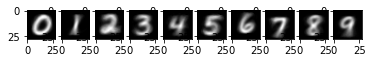

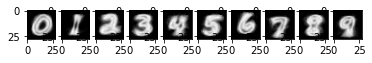

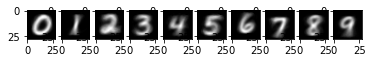

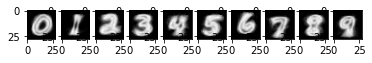

In [12]:
def P9():

    gnb = GaussianNB()
    gnb.fit(mini_train_data, mini_train_labels)
    print("Accuracy for Gaussian Naive Bayes: ", gnb.score(dev_data, dev_labels))
    theta1 = gnb.theta_  # sample means
    sigma1 = gnb.sigma_  # sample variances
    
    gnb = GaussianNB(var_smoothing=0.1)
    gnb.fit(mini_train_data, mini_train_labels)
    print("Accuracy for Gaussian Naive Bayes with var_smoothing: ",gnb.score(dev_data, dev_labels))
    theta2 = gnb.theta_  # sample means
    sigma2 = gnb.sigma_  # sample variances
    
    for i in range(theta1.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow(theta1[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.show()
    for i in range(sigma1.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow(sigma1[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.show()
    for i in range(theta2.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow(theta2[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.show()
    for i in range(sigma2.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow(sigma2[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.show()
    

P9()


**Output notes:**

- Model accuracy before fix is 0.593.

- Model accuracy after fix is 0.817.

- The model accuracy was fixed by adding `var_smoothing` parameter and setting it to 0.1 helped achieve almost around the same model accuracy as for a Bernoulli Naive Bayes model in part 7. 

- This could be achieved because of the var_smoothing parameter that added portion of the largest variance of all features to the variances for calculation stability.


### Part 10:

Because Naive Bayes produces a generative model, you can use it to generate digit images.

Produce a Bernoulli Naive Bayes model and then use it to generate a 10x20 grid with 20 example images of each digit. Each pixel output should be either 0 or 1, based on comparing some randomly generated number to the estimated probability of the pixel being either 0 or 1.  Show the grid.

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.

How do the generated digit images compare to the training digit images?

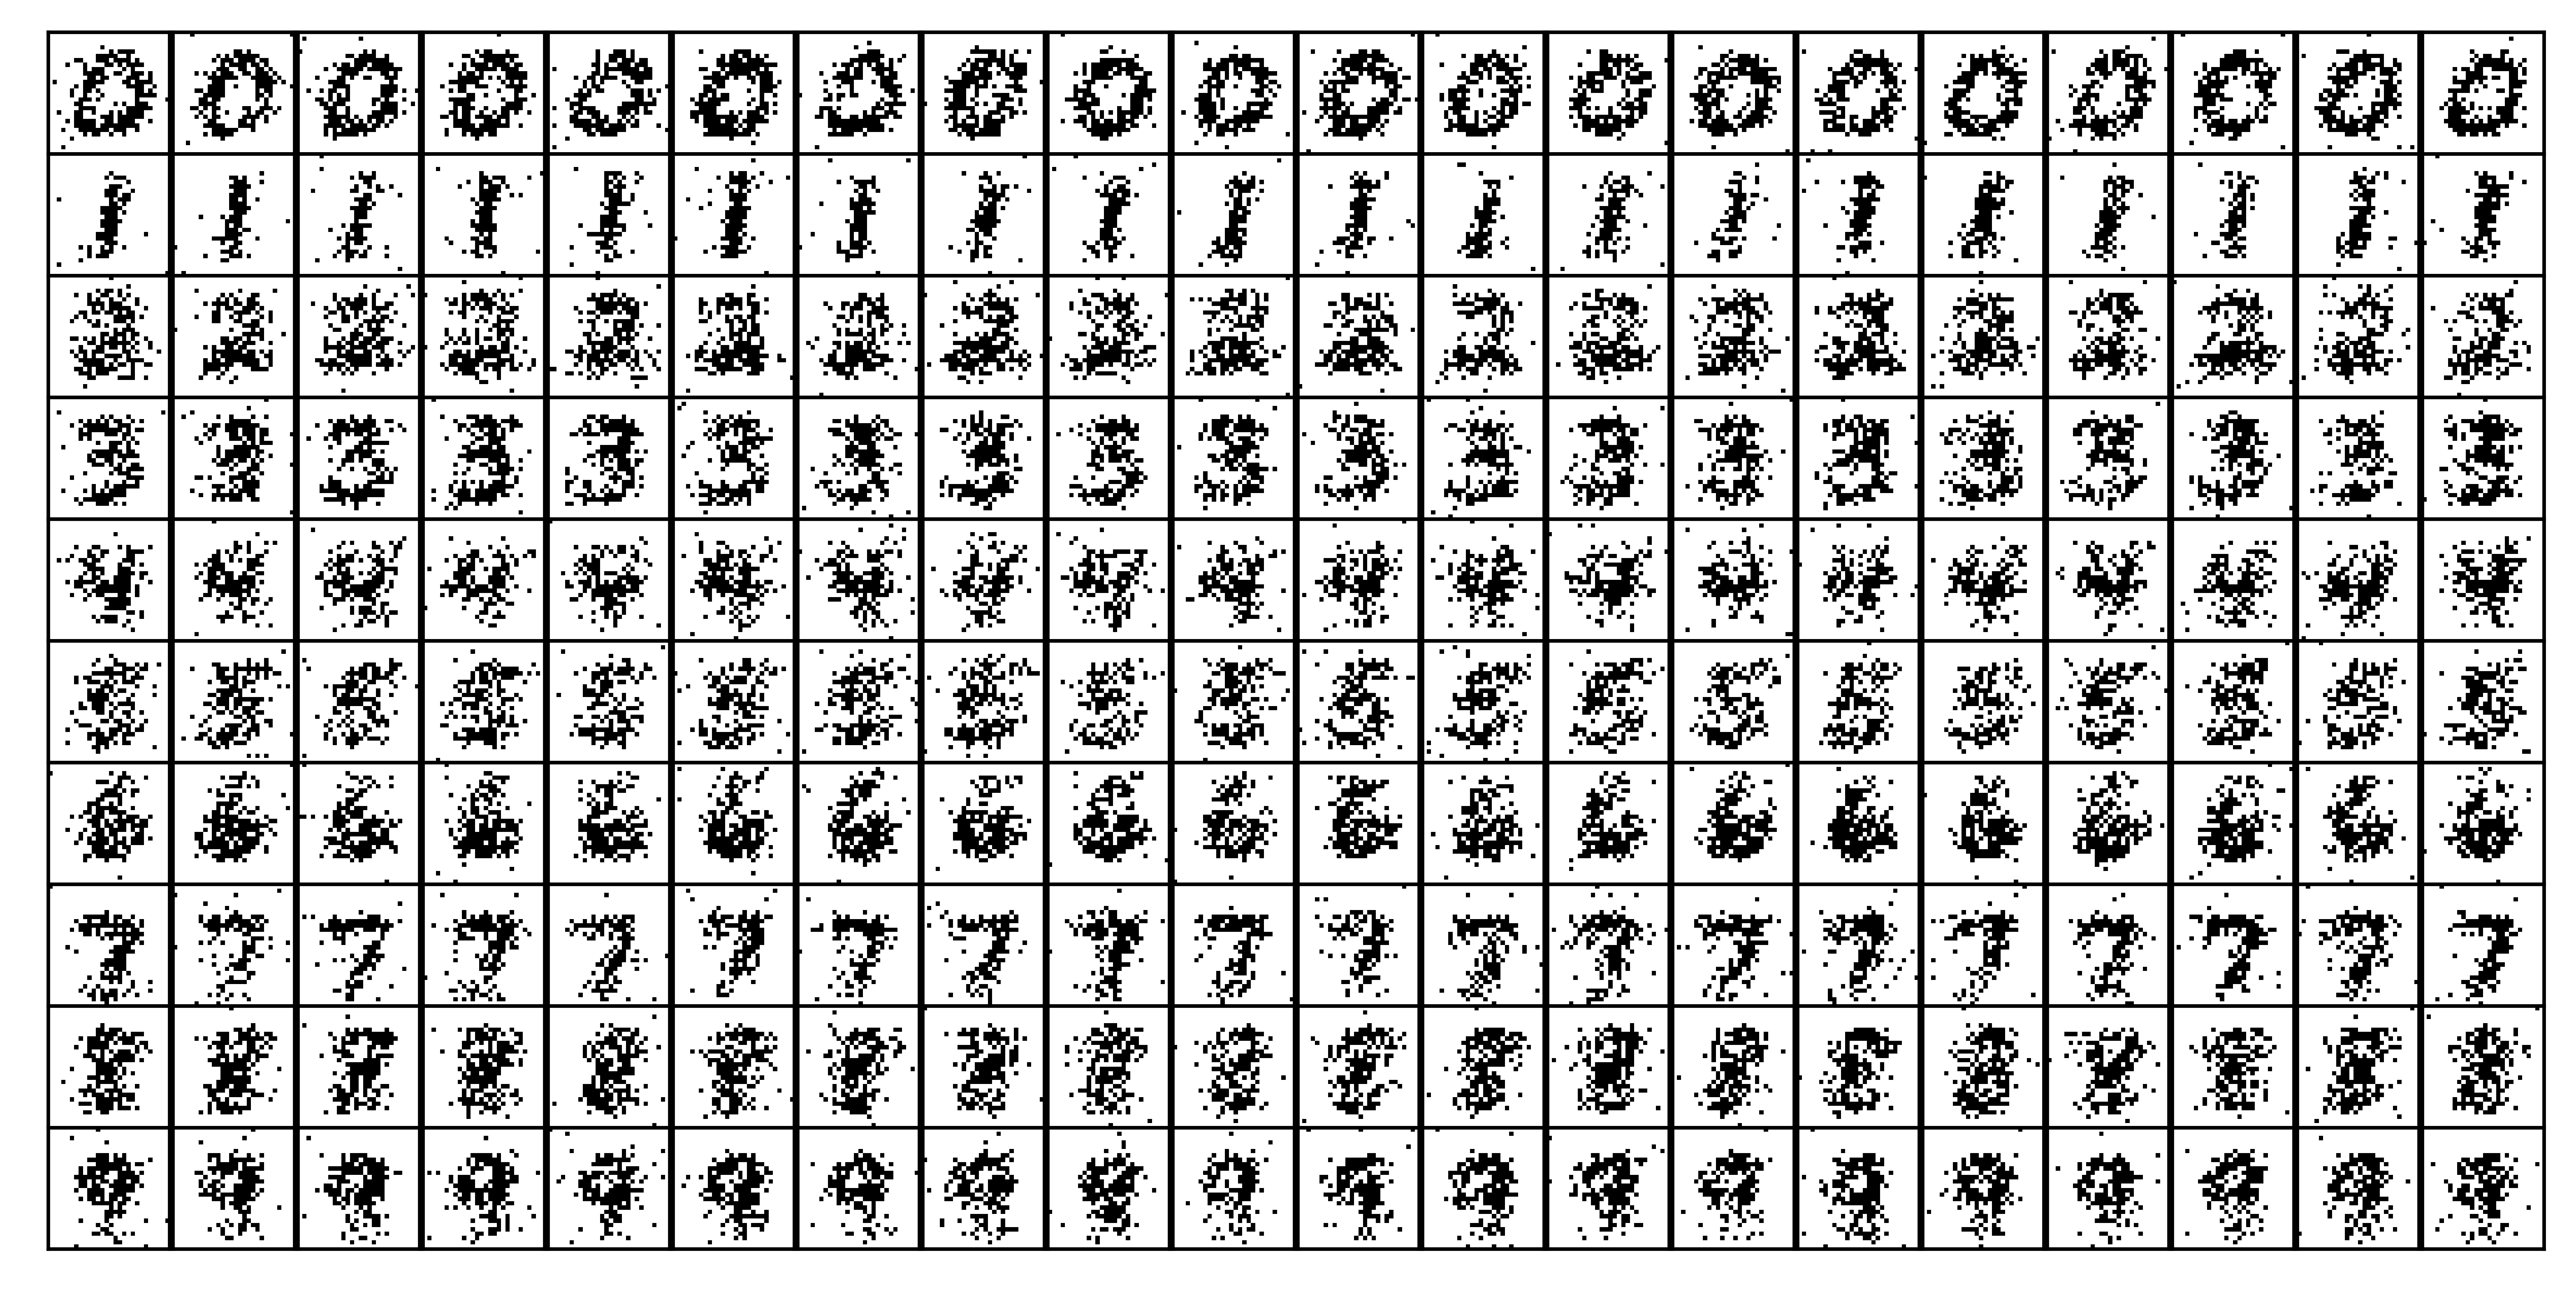

In [14]:
def P10(num_examples):

    BinomialNB_model = BernoulliNB(binarize=0.1)
    BinomialNB_model.fit(mini_train_data, mini_train_labels)
    probs = np.exp(BinomialNB_model.feature_log_prob_)
    plt.rc('image', cmap='Greys')
    plt.figure(figsize=(10, 5), dpi=X.shape[1])
    # For each digit (from 0 to 9)
    for i in range(len(np.unique(Y))):
        # Create a ndarray with the features of
        # "num_examples" examples of digit "i"
        # For each of the "num_examples" examples
        for j in range(num_examples):
        # Create subplot
        # (from 1 to "num_digits"*"num_examples" of each digit)
            example = np.where(probs[i,:]>np.random.rand(X.shape[1]),
                                   1,0)
            plt.subplot(len(np.unique(Y)), num_examples, 
                            i * num_examples + j + 1)
            plt.subplots_adjust(wspace=0, hspace=0)
            # Hide tickmarks and scale
            ax = plt.gca()
            # ax.set_axis_off() # Also hide axes (frame)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            # Plot the corresponding digit
            dim = int(np.sqrt(X.shape[1]))
            digit = example.reshape((dim,dim))
            plt.imshow(digit)

P10(20)


**Output notes:**

The generated digit images look much blurrier than the training digit images. However, some of the images are giving a general idea of the actual digits that they represent

### Part 11:

A strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior probability of the predicted class is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior probability and accuracy.  

Produce a Bernoulli Naive Bayes model.  Evaluate performance: partition the dev set into several buckets based on the posterior probabilities of the predicted classes - think of a bin in a histogram- and then estimate the accuracy for each bucket. So, for each prediction, find the bucket to which the maximum posterior probability belongs, and update "correct" and "total" counters accordingly.  Show the accuracy for each bucket.

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.

How would you characterize the calibration for this Bernoulli Naive Bayes model?

In [15]:
def P11(buckets, correct, total):
  
    max_probabilities = np.array([])
  
  
    #train model using reasonable alpha value
    model_p11 = BernoulliNB(alpha = .001, binarize = 0)
    #fit model using mini train data
    model_p11.fit(mini_train_data,mini_train_labels)
  

    probabilities = model_p11.predict_proba(dev_data)
    #print(probabilities.shape)
  
    #get max posterior probability for each digit in dev_data
    for i,v in enumerate(probabilities):
        max_probabilities = np.append(max_probabilities, np.max(probabilities[i]))

    #print(max_probabilities[21])
    #print(np.max(probabilities[0]))
  
    pred = model_p11.predict(dev_data) #train model
  
    #print(pred[0])
  
    #loop through max_probabilities array and determine counts for each bucket
    for index, p in np.ndenumerate(max_probabilities): #enumerate through our array of max posterior probabilities
        for index2, b in enumerate(buckets):
            if p <= b: #if max probabliity is less than or equal to value of probability bucket, add to bucket
                total[index2] = total[index2] + 1 #add to "total" for this bucket
        
                if pred[index] == dev_labels[index]: #does our predicted value match the label for this bucket?
                    correct[index2] = correct[index2] + 1 #if so, add to "correct" for this bucket
        
                break #break out of inner loop and continue to next item in max probabilities
        

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

P11(buckets, correct, total)

for i in range(len(buckets)):
    accuracy = 0.0
    if (total[i] > 0): 
        accuracy = correct[i] / total[i]
        print('p(pred) is %.13f to %.13f    total = %3d    accuracy = %.3f' % (0 if i==0 else buckets[i-1], buckets[i], total[i], accuracy))
        

p(pred) is 0.5000000000000 to 0.9000000000000    total =  31    accuracy = 0.355
p(pred) is 0.9000000000000 to 0.9990000000000    total =  67    accuracy = 0.433
p(pred) is 0.9990000000000 to 0.9999900000000    total =  59    accuracy = 0.458
p(pred) is 0.9999900000000 to 0.9999999000000    total =  46    accuracy = 0.652
p(pred) is 0.9999999000000 to 0.9999999990000    total =  62    accuracy = 0.774
p(pred) is 0.9999999990000 to 0.9999999999900    total =  33    accuracy = 0.788
p(pred) is 0.9999999999900 to 0.9999999999999    total =  43    accuracy = 0.791
p(pred) is 0.9999999999999 to 1.0000000000000    total = 659    accuracy = 0.938


**Output notes:**

Generally, a higher posterior probability results in higher accuracy, but that's not always true for above results. So it can be said that although there is a general trend of increasing accuracy as the posterior increases, but we cannot always infer the accuracy from the posterior.

As a result, I would characterize this classifier as weakly calibrated.

### Part 12:

Design new features to see if we can produce a Bernoulli Naive Bayes model with better performance.  Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

Here are a few ideas to get started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try counting the number of enclosed regions. (8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0)

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that code is well commented.

In [16]:
def P12():

    #initialize original model
    model_original = BernoulliNB(binarize = 0.1)

    model_original.fit(mini_train_data, mini_train_labels)
 
    pred_original = model_original.predict(dev_data)

    accuracy_original = 0

    for j in range(dev_labels.shape[0]):
        if pred_original[j] == dev_labels[j]:
            accuracy_original += 1
        else:
            continue
 
    print("Accuracy of model with original features: " + str(accuracy_original/pred_original.shape[0]))


  ####Part 1#####
  #We will be taking the average of each column/row for each image and return
  #the average for each value. Using this method, we should get 56 additional features
 
 
    def image_transformer(d1_image):
        d2_image = np.reshape(d1_image,(28,28))

        #initialize new array
        add_feature = np.zeros((56))
        count = 0

        #get sum of each row and write to new array iteratively
        for i in d2_image:
            add_feature[count] = np.sum(i)
            count += 1


        #get sum of each column and write to new array iteratively
        for i in range(28):    
            col_sum = 0 #set column value to 0 for each column we begin to iterate through
            for row in d2_image:
                col_sum = col_sum + row[i] #add value at ith column for each row
            add_feature[count] = col_sum
            count += 1
     
        #divide each item in array by 28 to return average
        for i in range(len(add_feature)):
            add_feature[i] = add_feature[i]/28

        add_feature = np.concatenate([d1_image, add_feature]) #add our additional 56 features to the new array
        return add_feature
   
    add_feature_mini_train_data = np.apply_along_axis(image_transformer, 1, mini_train_data)
       
    add_feature_dev_data = np.apply_along_axis(image_transformer, 1, dev_data)

    #initialize model
    model_add_feature = BernoulliNB(binarize = 0.1)

    model_add_feature.fit(add_feature_mini_train_data, mini_train_labels)
 
    pred_add_feature = model_add_feature.predict(add_feature_dev_data)

    accuracy_add_feature = 0

    for j in range(dev_labels.shape[0]):
        if pred_add_feature[j] == dev_labels[j]:
            accuracy_add_feature += 1
        else:
            continue
 
    print("Accuracy with adding two additional features (averaging the values of each row/column for 56 additional features): " + str(accuracy_add_feature/pred_add_feature.shape[0]))

 
    ####Part 2: Let us try running a blurring function against our training and dev data as well####
 
    #### Blurring function####
    def gaussian_blur(d1_image):
        dim = 28
        d2_image = d1_image.reshape(dim, dim)
        d2_blur_image = np.zeros((dim, dim), dtype=float)
        mask_blur = np.array([[.0625, .125, .0625], [.125, .25, .125] , [.0625 , .125, .0625] ])
        for i in range(1,dim-1):
            for j in range(1,dim-1):
                d2_blur_image[i][j] = d2_image[i-1][j-1]*mask_blur[0][0] + \
                                    d2_image[i-1][j]*mask_blur[0][1] + \
                                    d2_image[i-1][j+1]*mask_blur[0][2] + \
                                    d2_image[i][j-1]*mask_blur[1][0] + \
                                    d2_image[i][j]*mask_blur[1][1] + \
                                    d2_image[i][j+1]*mask_blur[1][2] + \
                                    d2_image[i+1][j-1]*mask_blur[2][0] +\
                                    d2_image[i+1][j]*mask_blur[2][1] + \
                                    d2_image[i+1][j+1]*mask_blur[2][2]
        return d2_blur_image.flatten()

    blur_mini_train_data = np.apply_along_axis(gaussian_blur, 1, mini_train_data)
    blur_dev_data = np.apply_along_axis(gaussian_blur, 1, dev_data)
   

    #initialize model
    model_blur = BernoulliNB(binarize = 0.1)
    model_blur.fit(blur_mini_train_data, mini_train_labels)
 
    pred_blur = model_blur.predict(blur_dev_data)

    accuracy_count_blur = 0

    for j in range(dev_labels.shape[0]):
        if pred_blur[j] == dev_labels[j]:
            accuracy_count_blur += 1
        else:
            continue
 
    print("Accuracy with additional added features (apply blurring function then run Naive Bayes): " + str(accuracy_count_blur/pred_blur.shape[0]))

P12()


Accuracy of model with original features: 0.814
Accuracy with adding two additional features (averaging the values of each row/column for 56 additional features): 0.815
Accuracy with additional added features (apply blurring function then run Naive Bayes): 0.814
